In [6]:
import os, sys, uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import HomeMade as hm
import seaborn as sb
from iminuit import Minuit
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
import dill
from AppStatFunctions import Chi2Regression,UnbinnedLH, BinnedLH, add_text_to_ax, nice_string_output
from sklearn.preprocessing import RobustScaler
from hep_ml.reweight import GBReweighter

In [7]:
Nmax=2.4e6
uncorrelated=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']

In [147]:
N = 5e5
if N>Nmax:
    N=Nmax
    print('Maxed out')

all_features = np.hstack((['v0_ks_mass'], uncorrelated))

path = "../../data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "../../data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(np.hstack((all_features ,['trueKs'])), entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_data = data.sample(frac=0.7)
test_data = data[~data.index.isin(train_data.index)]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_mc = mc.sample(frac=0.7)
test_mc = mc[~mc.index.isin(train_mc.index)]

In [101]:

from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}

def draw_distributions(original, target, new_original_weights, plot=True, verbose=True):
    s=[]
    plt.figure(figsize=[20, 20])
    for id, column in enumerate(original.columns, 1):
        print(column)
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        if plot:
            plt.subplot(5, 4, id)
            plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
            plt.hist(target[column], range=xlim, **hist_settings)
            plt.title(column)
        kstest=ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float))
        if verbose:
            print('KS over ', column, ' = ',kstest)
        s.append(kstest)
    return np.sum(s)/len(s), np.array(s)

In [62]:
def compare_distributions(original, target, new_original_weights):
    s=[]
    for id, column in enumerate(original.columns, 1):
        s.append(ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float)))
    return np.sum(s)/len(s), s

In [63]:
mcweights_train = np.ones(len(mc_train))
mcweights_test = np.ones(len(mc_test))

In [145]:
def scale_split(mcs, datas, split, paramlist, no_transform):
    mc1, data1=mcs[paramlist], datas[paramlist]
    testlen=int(len(mc)*(1-split))
    mct, datat=RobustScaler().fit(mc1), RobustScaler().fit(mc1)
    mc1, data1=mct.transform(mc1), datat.transform(data1)
    mc1, data1=pd.DataFrame(mc1, columns=paramlist), pd.DataFrame(data1, columns=paramlist)
    for no in no_transform:
        mc1[no]=mcs[no].to_numpy()
        data1[no]=datas[no].to_numpy()
    true=mc.trueKs
    return mc1[:testlen], mc1[testlen:], data1[:testlen], data1[testlen:], true[:testlen], true[testlen:]

Checking out the scaled stuff

v0_chi2
KS over  v0_chi2  =  0.07580963288159775
v0_px1
KS over  v0_px1  =  0.08980721511745005
v0_phi1
KS over  v0_phi1  =  0.05144111471653917
v0_py1
KS over  v0_py1  =  0.09731500922574532
v0_py
KS over  v0_py  =  0.1304002036012849
v0_py2
KS over  v0_py2  =  0.10272316599867004
v0_phi2
KS over  v0_phi2  =  0.04552395495322664
v0_px2
KS over  v0_px2  =  0.10132340777508975
v0_px
KS over  v0_px  =  0.13956225742835737
cosTheta
KS over  cosTheta  =  0.18575427880635254
a0xy
KS over  a0xy  =  0.22755614939243474
a0
KS over  a0  =  0.443564293440443
v0_y
KS over  v0_y  =  0.09604250174967938
v0_x
KS over  v0_x  =  0.08878920913658667
v0_rxyErr
KS over  v0_rxyErr  =  0.10412292422215982
v0_z
KS over  v0_z  =  0.1263918050519408
pv0_z
KS over  pv0_z  =  0.4247629954825574
pv0_y


invalid value encountered in true_divide


KS over  pv0_y  =  0.9999681873130745
ntrk_pv0
KS over  ntrk_pv0  =  0.38242030921926184
pv0_x
KS over  pv0_x  =  0.9998409365654789


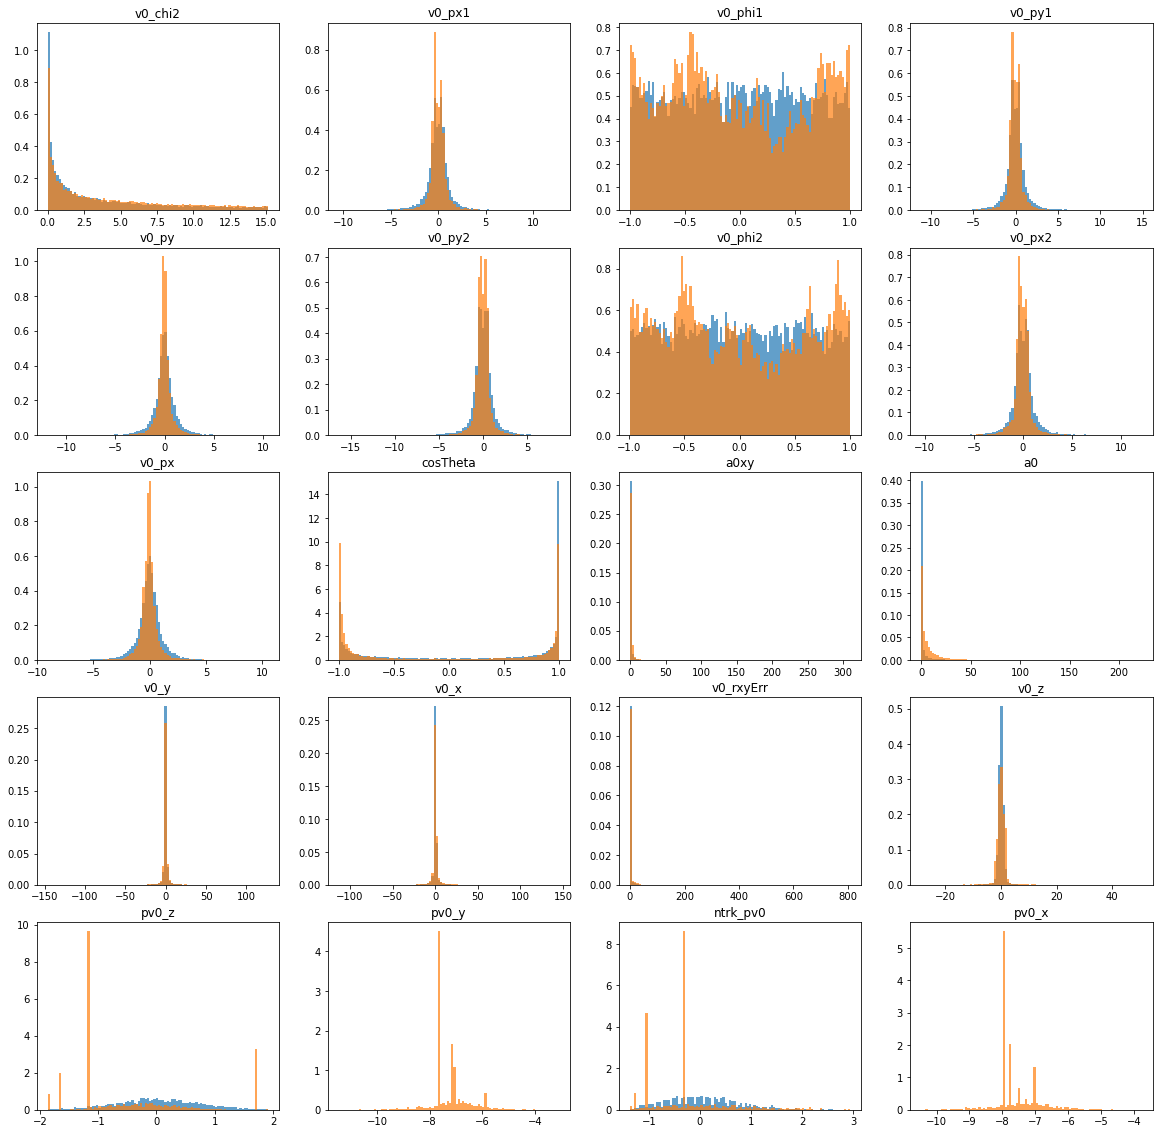

In [66]:
s, sarray=draw_distributions(mc_test, data_test, mcweights_test)

Checking out the non_scaled population

v0_chi2
KS over  v0_chi2  =  0.08555950574034349
v0_px1
KS over  v0_px1  =  0.09874237380488612
v0_phi1
KS over  v0_phi1  =  0.03960570707132685
v0_py1
KS over  v0_py1  =  0.09536328060952204
v0_py
KS over  v0_py  =  0.12400151362018771
v0_py2
KS over  v0_py2  =  0.10458228612637319
v0_phi2
KS over  v0_phi2  =  0.040805066760561615
v0_px2
KS over  v0_px2  =  0.09718433783311131
v0_px
KS over  v0_px  =  0.11367686452625789
cosTheta
KS over  cosTheta  =  0.19105596419594445
a0xy
KS over  a0xy  =  0.2513236667256908
a0
KS over  a0  =  0.501684167886389
v0_y
KS over  v0_y  =  0.10974366142049008
v0_x
KS over  v0_x  =  0.10260117287667983
v0_rxyErr
KS over  v0_rxyErr  =  0.12442970018685179
v0_z
KS over  v0_z  =  0.1587497702179028
pv0_z
KS over  pv0_z  =  0.3480302715110252
pv0_y
KS over  pv0_y  =  0.9998759328892085
ntrk_pv0
KS over  ntrk_pv0  =  0.4589170170590553
pv0_x
KS over  pv0_x  =  0.999980912752159


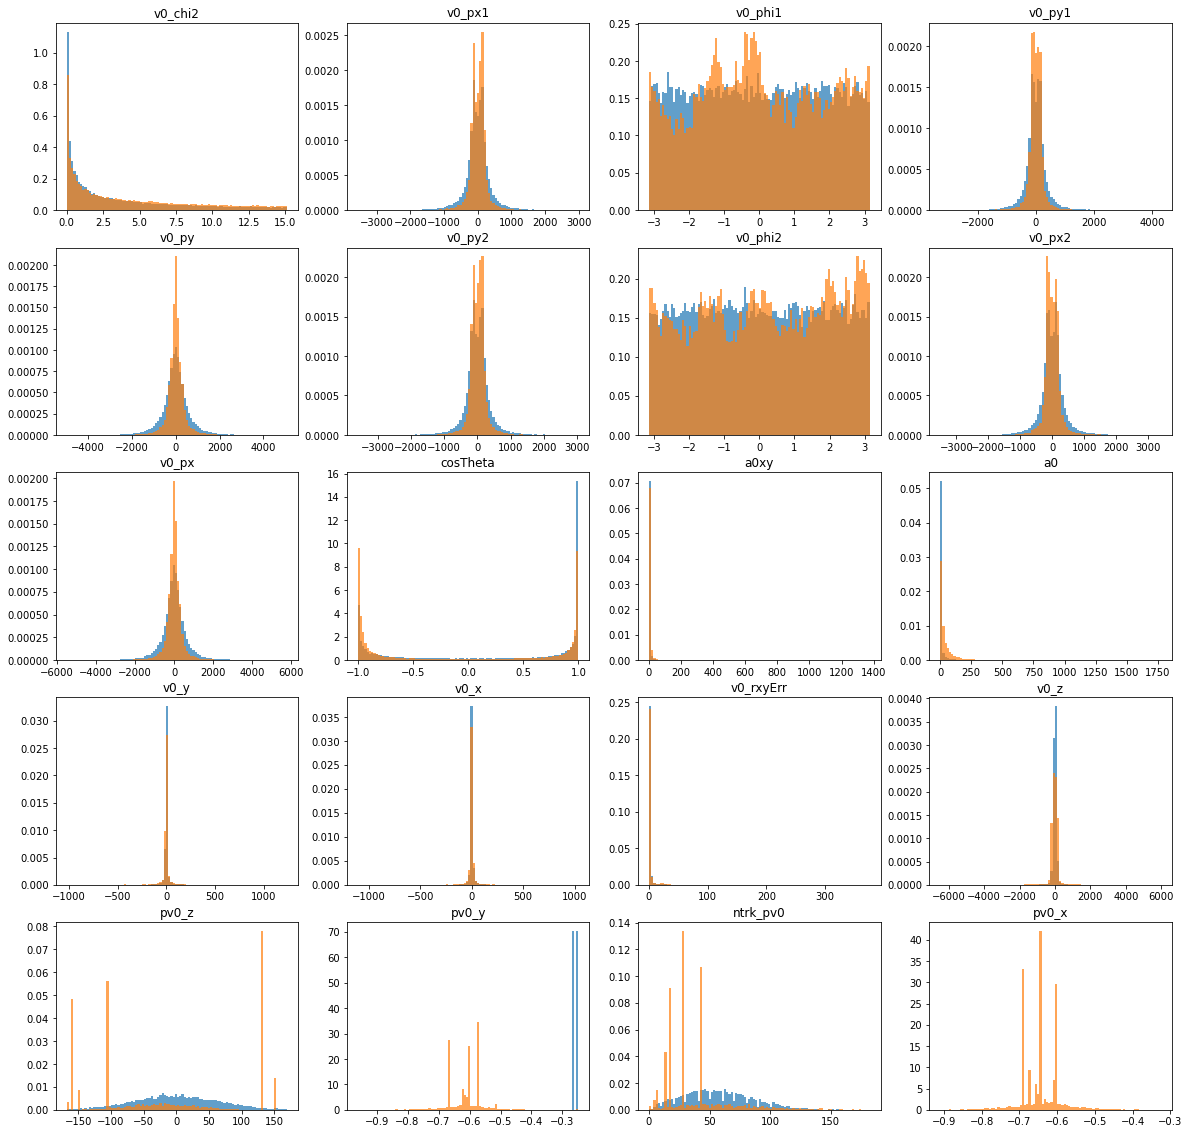

In [68]:
sorig, sorigarray=draw_distributions(mc[uncorrelated], data[uncorrelated], np.ones(len(mc)))

In [70]:
sorig/s

1.027028371756163

In [198]:
sorig

0.2522956586906983

### We gain a bit with the new scaled and centereed distributions, about 3%

['a0', 'v0_rxyErr']

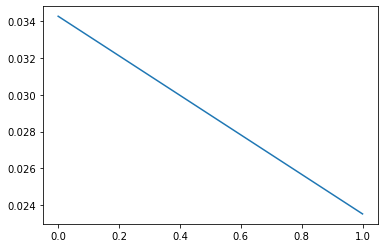

In [163]:
plt.plot(slist)
extra

['a0xy', 'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z']

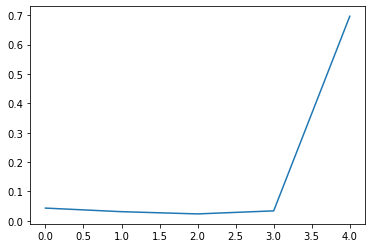

In [157]:
plt.plot(slist)
extra

In [242]:
paramsure=['v0_ks_mass','v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'v0_x', 'v0_rxyErr', 'v0_z' ]
extra=[ 'a0xy', 'a0,' 'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z']
extra=[ 'a0xy', 'v0_rxyErr']

In [243]:
features=paramsure
slist=[]
#trying to add ks mass to non scaled
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, features, ['v0_chi2', 'cosTheta', 'v0_ks_mass'])
reweighter = GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_leaf=1000)
reweighter.fit(mc_train[features], data_train[features])

GBReweighter(gb_args={}, learning_rate=0.1, max_depth=5, min_samples_leaf=1000,
             n_estimators=50)

v0_ks_mass
v0_chi2
v0_px1
v0_phi1
v0_py1
v0_py
v0_py2
v0_phi2
v0_px2
v0_px
cosTheta
a0xy
v0_x
v0_rxyErr
v0_z


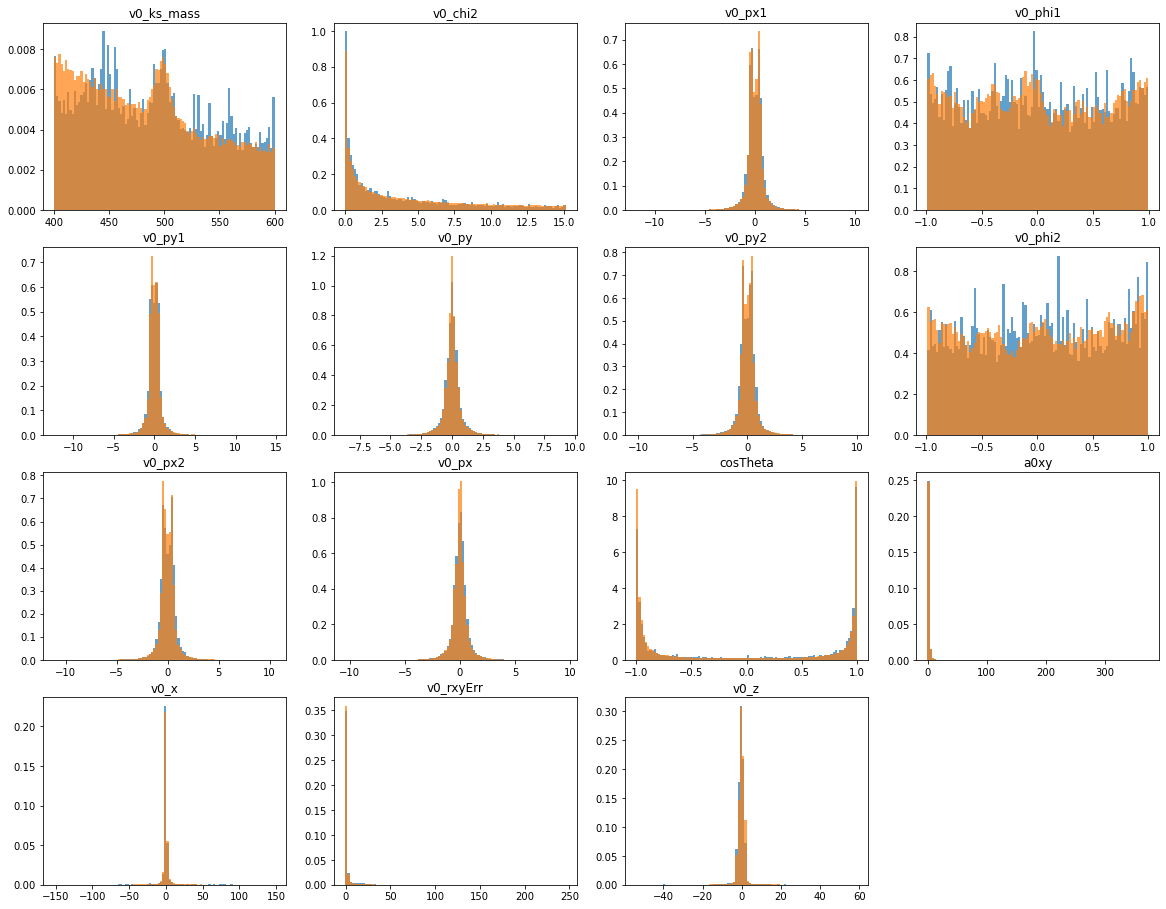

In [244]:
gb_weights_test = reweighter.predict_weights(mc_test[features])
# validate reweighting rule on the test part comparing 1d projections
s, _ =draw_distributions(mc_test[features], data_test[features], gb_weights_test, verbose=0)
slist.append(s)

In [245]:
s, sorig/s

(0.04066797915078954, 6.2037913847460056)

## 6 times better! Watch out for disturbance in mass though

In [246]:
#NAMES: mc_test, mc_train, data_test, data_train, truetest, truetrain
params=features[1:]
import xgboost
train_weights = reweighter.predict_weights(mc_train[paramsure])
test_weights = reweighter.predict_weights(mc_test[paramsure])
eval_s = [(mc_train[params], truetrain), (mc_test[params], truetest)]
model = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 1000)
model.fit(mc_train[params], truetrain, sample_weight=train_weights, verbose=True,eval_set=eval_s,
          early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.970901	validation_1-auc:0.970744
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.971288	validation_1-auc:0.971086
[2]	validation_0-auc:0.974153	validation_1-auc:0.973545
[3]	validation_0-auc:0.974665	validation_1-auc:0.974044
[4]	validation_0-auc:0.974883	validation_1-auc:0.974325
[5]	validation_0-auc:0.975084	validation_1-auc:0.974422
[6]	validation_0-auc:0.975094	validation_1-auc:0.974422
[7]	validation_0-auc:0.976358	validation_1-auc:0.975693
[8]	validation_0-auc:0.976739	validation_1-auc:0.975988
[9]	validation_0-auc:0.976692	validation_1-auc:0.975946
[10]	validation_0-auc:0.976841	validation_1-auc:0.97607
[11]	validation_0-auc:0.976864	validation_1-auc:0.976103
[12]	validation_0-auc:0.97686	validation_1-auc:0.976106
[13]	validation_0-auc:0.976881	validation_1-auc:0.976125
[14]	validation_0-auc:0.976879	validation_1-auc:0.976115


[142]	validation_0-auc:0.981977	validation_1-auc:0.981271
[143]	validation_0-auc:0.981984	validation_1-auc:0.981276
[144]	validation_0-auc:0.981977	validation_1-auc:0.98128
[145]	validation_0-auc:0.981989	validation_1-auc:0.981302
[146]	validation_0-auc:0.982013	validation_1-auc:0.981318
[147]	validation_0-auc:0.982015	validation_1-auc:0.981322
[148]	validation_0-auc:0.982027	validation_1-auc:0.981339
[149]	validation_0-auc:0.98203	validation_1-auc:0.981341
[150]	validation_0-auc:0.982043	validation_1-auc:0.981357
[151]	validation_0-auc:0.982047	validation_1-auc:0.98136
[152]	validation_0-auc:0.982052	validation_1-auc:0.981365
[153]	validation_0-auc:0.982056	validation_1-auc:0.981367
[154]	validation_0-auc:0.982065	validation_1-auc:0.981373
[155]	validation_0-auc:0.982086	validation_1-auc:0.981402
[156]	validation_0-auc:0.982373	validation_1-auc:0.981745
[157]	validation_0-auc:0.98237	validation_1-auc:0.981738
[158]	validation_0-auc:0.982344	validation_1-auc:0.981755
[159]	validation_0

[284]	validation_0-auc:0.984489	validation_1-auc:0.983804
[285]	validation_0-auc:0.984505	validation_1-auc:0.983822
[286]	validation_0-auc:0.984504	validation_1-auc:0.983822
[287]	validation_0-auc:0.984537	validation_1-auc:0.983857
[288]	validation_0-auc:0.984554	validation_1-auc:0.983879
[289]	validation_0-auc:0.984595	validation_1-auc:0.983918
[290]	validation_0-auc:0.984596	validation_1-auc:0.983919
[291]	validation_0-auc:0.984614	validation_1-auc:0.983942
[292]	validation_0-auc:0.984635	validation_1-auc:0.983957
[293]	validation_0-auc:0.984649	validation_1-auc:0.98397
[294]	validation_0-auc:0.984677	validation_1-auc:0.983988
[295]	validation_0-auc:0.984706	validation_1-auc:0.984015
[296]	validation_0-auc:0.984741	validation_1-auc:0.984052
[297]	validation_0-auc:0.984742	validation_1-auc:0.984051
[298]	validation_0-auc:0.984757	validation_1-auc:0.984067
[299]	validation_0-auc:0.984771	validation_1-auc:0.984086
[300]	validation_0-auc:0.984795	validation_1-auc:0.984109
[301]	validatio

[426]	validation_0-auc:0.986278	validation_1-auc:0.985458
[427]	validation_0-auc:0.986295	validation_1-auc:0.985475
[428]	validation_0-auc:0.986321	validation_1-auc:0.985504
[429]	validation_0-auc:0.986331	validation_1-auc:0.985512
[430]	validation_0-auc:0.986335	validation_1-auc:0.985516
[431]	validation_0-auc:0.986339	validation_1-auc:0.985515
[432]	validation_0-auc:0.98635	validation_1-auc:0.985526
[433]	validation_0-auc:0.986357	validation_1-auc:0.985535
[434]	validation_0-auc:0.98637	validation_1-auc:0.985545
[435]	validation_0-auc:0.986378	validation_1-auc:0.985551
[436]	validation_0-auc:0.98638	validation_1-auc:0.985553
[437]	validation_0-auc:0.98638	validation_1-auc:0.98555
[438]	validation_0-auc:0.986399	validation_1-auc:0.985564
[439]	validation_0-auc:0.986402	validation_1-auc:0.985568
[440]	validation_0-auc:0.986412	validation_1-auc:0.98558
[441]	validation_0-auc:0.986422	validation_1-auc:0.985587
[442]	validation_0-auc:0.986426	validation_1-auc:0.985588
[443]	validation_0-a

[568]	validation_0-auc:0.987372	validation_1-auc:0.98644
[569]	validation_0-auc:0.987373	validation_1-auc:0.986439
[570]	validation_0-auc:0.987374	validation_1-auc:0.98644
[571]	validation_0-auc:0.987394	validation_1-auc:0.986458
[572]	validation_0-auc:0.987396	validation_1-auc:0.986459
[573]	validation_0-auc:0.9874	validation_1-auc:0.986461
[574]	validation_0-auc:0.987403	validation_1-auc:0.986463
[575]	validation_0-auc:0.98741	validation_1-auc:0.986472
[576]	validation_0-auc:0.987416	validation_1-auc:0.986486
[577]	validation_0-auc:0.987436	validation_1-auc:0.986506
[578]	validation_0-auc:0.987452	validation_1-auc:0.986525
[579]	validation_0-auc:0.987462	validation_1-auc:0.986535
[580]	validation_0-auc:0.987465	validation_1-auc:0.986538
[581]	validation_0-auc:0.987471	validation_1-auc:0.986546
[582]	validation_0-auc:0.987479	validation_1-auc:0.986552
[583]	validation_0-auc:0.987479	validation_1-auc:0.986552
[584]	validation_0-auc:0.987497	validation_1-auc:0.986569
[585]	validation_0-

[710]	validation_0-auc:0.988259	validation_1-auc:0.9873
[711]	validation_0-auc:0.988263	validation_1-auc:0.987305
[712]	validation_0-auc:0.988263	validation_1-auc:0.987306
[713]	validation_0-auc:0.988271	validation_1-auc:0.987314
[714]	validation_0-auc:0.988276	validation_1-auc:0.98732
[715]	validation_0-auc:0.988284	validation_1-auc:0.987328
[716]	validation_0-auc:0.988285	validation_1-auc:0.987327
[717]	validation_0-auc:0.988293	validation_1-auc:0.987333
[718]	validation_0-auc:0.988304	validation_1-auc:0.987346
[719]	validation_0-auc:0.988306	validation_1-auc:0.987349
[720]	validation_0-auc:0.98831	validation_1-auc:0.987347
[721]	validation_0-auc:0.988315	validation_1-auc:0.987352
[722]	validation_0-auc:0.988326	validation_1-auc:0.987364
[723]	validation_0-auc:0.98833	validation_1-auc:0.987371
[724]	validation_0-auc:0.988338	validation_1-auc:0.987379
[725]	validation_0-auc:0.988339	validation_1-auc:0.987381
[726]	validation_0-auc:0.988343	validation_1-auc:0.987385
[727]	validation_0-

[852]	validation_0-auc:0.988903	validation_1-auc:0.987864
[853]	validation_0-auc:0.988912	validation_1-auc:0.987872
[854]	validation_0-auc:0.988925	validation_1-auc:0.987882
[855]	validation_0-auc:0.988926	validation_1-auc:0.987883
[856]	validation_0-auc:0.988934	validation_1-auc:0.987891
[857]	validation_0-auc:0.988935	validation_1-auc:0.987889
[858]	validation_0-auc:0.988935	validation_1-auc:0.987887
[859]	validation_0-auc:0.988938	validation_1-auc:0.987894
[860]	validation_0-auc:0.98894	validation_1-auc:0.987895
[861]	validation_0-auc:0.988945	validation_1-auc:0.987899
[862]	validation_0-auc:0.988947	validation_1-auc:0.9879
[863]	validation_0-auc:0.98896	validation_1-auc:0.987912
[864]	validation_0-auc:0.988968	validation_1-auc:0.987919
[865]	validation_0-auc:0.988971	validation_1-auc:0.987921
[866]	validation_0-auc:0.988974	validation_1-auc:0.987927
[867]	validation_0-auc:0.988978	validation_1-auc:0.987934
[868]	validation_0-auc:0.988978	validation_1-auc:0.987932
[869]	validation_0

[994]	validation_0-auc:0.989375	validation_1-auc:0.988239
[995]	validation_0-auc:0.989377	validation_1-auc:0.988242
[996]	validation_0-auc:0.989378	validation_1-auc:0.988243
[997]	validation_0-auc:0.989378	validation_1-auc:0.98824
[998]	validation_0-auc:0.989382	validation_1-auc:0.988246
[999]	validation_0-auc:0.989386	validation_1-auc:0.98825


XGBClassifier(learning_rate=0.02, n_estimators=1000)

In [247]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(mc_train[params])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, mc_train[params])

KeyboardInterrupt: 

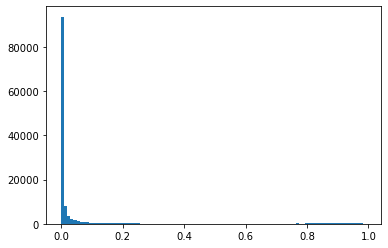

In [248]:
pxg=model.predict_proba(data_train[params])[:,1]
plt.hist(pxg, bins=100);
# plt.yscale('log')

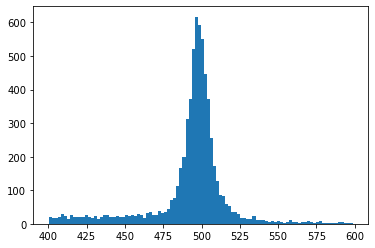

In [249]:
true=pxg>0.7
plt.hist(data_train.v0_ks_mass[true], bins=100);

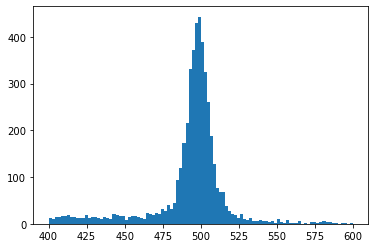

In [250]:
#just for fun
pxgt=model.predict_proba(data_test[params])[:,1]
truetest=pxgt>0.7
plt.hist(data_test.v0_ks_mass[truetest], bins=100);

In [251]:
eval_s = [(data_train[params], true), (data_test[params], truetest)]
# tsts.append(X_train)
modeldata = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldata.fit(data_train[params], true,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.988976	validation_1-auc:0.98997
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.989636	validation_1-auc:0.990643
[2]	validation_0-auc:0.989666	validation_1-auc:0.990659
[3]	validation_0-auc:0.989636	validation_1-auc:0.990643
[4]	validation_0-auc:0.989668	validation_1-auc:0.990662
[5]	validation_0-auc:0.989751	validation_1-auc:0.990731
[6]	validation_0-auc:0.989781	validation_1-auc:0.990747
[7]	validation_0-auc:0.989752	validation_1-auc:0.990731
[8]	validation_0-auc:0.991308	validation_1-auc:0.992427
[9]	validation_0-auc:0.991578	validation_1-auc:0.992604
[10]	validation_0-auc:0.993265	validation_1-auc:0.993526
[11]	validation_0-auc:0.993588	validation_1-auc:0.99378
[12]	validation_0-auc:0.993682	validation_1-auc:0.993883
[13]	validation_0-auc:0.993683	validation_1-auc:0.993884
[14]	validation_0-auc:0.993805	validation_1-auc:0.994042


[142]	validation_0-auc:0.997717	validation_1-auc:0.997566
[143]	validation_0-auc:0.997723	validation_1-auc:0.997572
[144]	validation_0-auc:0.997732	validation_1-auc:0.997578
[145]	validation_0-auc:0.997736	validation_1-auc:0.997581
[146]	validation_0-auc:0.99774	validation_1-auc:0.997586
[147]	validation_0-auc:0.997745	validation_1-auc:0.997588
[148]	validation_0-auc:0.997749	validation_1-auc:0.997591
[149]	validation_0-auc:0.997753	validation_1-auc:0.997594
[150]	validation_0-auc:0.997759	validation_1-auc:0.997598
[151]	validation_0-auc:0.997774	validation_1-auc:0.997613
[152]	validation_0-auc:0.997778	validation_1-auc:0.997618
[153]	validation_0-auc:0.997784	validation_1-auc:0.997623
[154]	validation_0-auc:0.997788	validation_1-auc:0.997626
[155]	validation_0-auc:0.997793	validation_1-auc:0.99763
[156]	validation_0-auc:0.997802	validation_1-auc:0.997637
[157]	validation_0-auc:0.997804	validation_1-auc:0.997642
[158]	validation_0-auc:0.99781	validation_1-auc:0.997645
[159]	validation_

XGBClassifier(learning_rate=0.02, n_estimators=200)

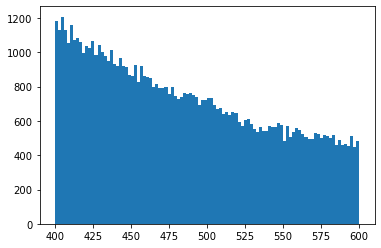

In [252]:
p_final=modeldata.predict_proba(data_test[params])[:,0]
true_final=p_final>0.75
plt.hist(data_test.v0_ks_mass[true_final], bins=100);

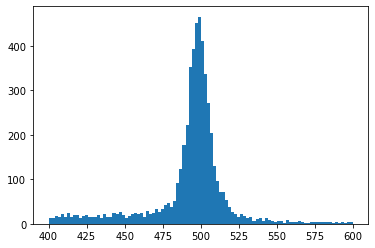

In [253]:
plt.hist(data_test.v0_ks_mass[~true_final], bins=100);

Completed fit with Chi2: 95.2, p-val: 0.361 and the total amount of signal 4209 +/- 146, background: 74357
Completed fit with Chi2: 94.3, p-val: 0.386 and the total amount of signal 3508 +/- 171, background: 74273
Completed fit with Chi2: 93.2, p-val: 0.415 and the total amount of signal 2845 +/- 164, background: 74149
Completed fit with Chi2: 92.7, p-val: 0.430 and the total amount of signal 2187 +/- 177, background: 74023
Completed fit with Chi2: 92.1, p-val: 0.449 and the total amount of signal 1563 +/- 42, background: 73860
Completed fit with Chi2: 90.8, p-val: 0.486 and the total amount of signal 1035 +/- 348, background: 73603
Completed fit with Chi2: 93.9, p-val: 0.397 and the total amount of signal 615 +/- 152, background: 73238
Completed fit with Chi2: 95.1, p-val: 0.363 and the total amount of signal 346 +/- 73, background: 72721
Completed fit with Chi2: 95.3, p-val: 0.358 and the total amount of signal 140 +/- 136, background: 72140
Completed fit with Chi2: 94.3, p-val: 0.38

Completed fit with Chi2: 94.1, p-val: 0.391 and the total amount of signal 93 +/- 57, background: 15621
Completed fit with Chi2: 93.8, p-val: 0.398 and the total amount of signal 77 +/- 57, background: 14851
Completed fit with Chi2: 95.3, p-val: 0.357 and the total amount of signal 70 +/- 56, background: 14072
No valid minimum found!
Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 57 +/- 3565, background: 13300
Completed fit with Chi2: 103.8, p-val: 0.169 and the total amount of signal 52 +/- 11, background: 12519
Completed fit with Chi2: 100.9, p-val: 0.223 and the total amount of signal 38 +/- 0, background: 11747
Completed fit with Chi2: 98.0, p-val: 0.290 and the total amount of signal 25 +/- 25, background: 10975
Completed fit with Chi2: 93.4, p-val: 0.410 and the total amount of signal 22 +/- 26, background: 10192
Completed fit with Chi2: 99.8, p-val: 0.248 and the total amount of signal 12 +/- 25, background: 9417
Completed fit with Chi2: 101.3, p-val:

-0.025700767390399573

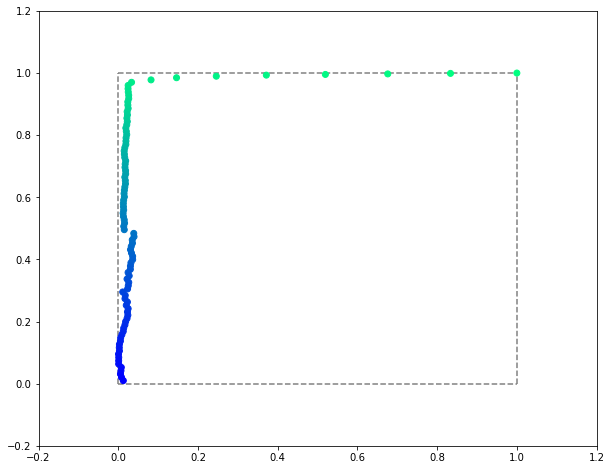

In [258]:
fig1, ax1=plt.subplots(figsize=(10,8))
hm.roc_curve_data(data_test.v0_ks_mass, p_final, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = True, plimit = 0.01)

In [268]:
mc_test, mc_train, data_test, data_train, truetest, truetrain=scale_split(mc, data, 0.7, np.hstack((uncorrelated, ['v0_ks_mass'])), ['v0_chi2','v0_ks_mass', 'cosTheta'])
eval_s = [(mc_train[uncorrelated], truetrain), (mc_test[uncorrelated], truetest)]
model = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 100)
model.fit(mc_train[uncorrelated], truetrain, verbose=True,eval_set=eval_s,
          early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.975326	validation_1-auc:0.974987
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.975381	validation_1-auc:0.975036
[2]	validation_0-auc:0.975513	validation_1-auc:0.975148
[3]	validation_0-auc:0.97553	validation_1-auc:0.975171
[4]	validation_0-auc:0.976209	validation_1-auc:0.97575
[5]	validation_0-auc:0.976456	validation_1-auc:0.976037
[6]	validation_0-auc:0.976725	validation_1-auc:0.976238
[7]	validation_0-auc:0.976828	validation_1-auc:0.976333
[8]	validation_0-auc:0.976838	validation_1-auc:0.976336
[9]	validation_0-auc:0.976892	validation_1-auc:0.97638
[10]	validation_0-auc:0.976895	validation_1-auc:0.976384
[11]	validation_0-auc:0.976941	validation_1-auc:0.976426
[12]	validation_0-auc:0.976949	validation_1-auc:0.976439
[13]	validation_0-auc:0.976981	validation_1-auc:0.976488
[14]	validation_0-auc:0.97703	validation_1-auc:0.976539
[1

XGBClassifier(learning_rate=0.02)

Exception ignored in: <function Booster.__del__ at 0x000001449FD333A8>
Traceback (most recent call last):
  File "C:\Users\chris\Anaconda3\lib\site-packages\xgboost\core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


[0]	validation_0-auc:0.996553	validation_1-auc:0.995893
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.996553	validation_1-auc:0.995893
[2]	validation_0-auc:0.996565	validation_1-auc:0.995896
[3]	validation_0-auc:0.996569	validation_1-auc:0.995901
[4]	validation_0-auc:0.996811	validation_1-auc:0.996199
[5]	validation_0-auc:0.996852	validation_1-auc:0.996224
[6]	validation_0-auc:0.996853	validation_1-auc:0.996227
[7]	validation_0-auc:0.996853	validation_1-auc:0.996227
[8]	validation_0-auc:0.996859	validation_1-auc:0.996226
[9]	validation_0-auc:0.998868	validation_1-auc:0.998093
[10]	validation_0-auc:0.998868	validation_1-auc:0.998093
[11]	validation_0-auc:0.998868	validation_1-auc:0.998094
[12]	validation_0-auc:0.998866	validation_1-auc:0.998096
[13]	validation_0-auc:0.998871	validation_1-auc:0.998104
[14]	validation_0-auc:0.998921	validation_1-auc:0.99814

[141]	validation_0-auc:0.999948	validation_1-auc:0.999886
[142]	validation_0-auc:0.99995	validation_1-auc:0.999887
[143]	validation_0-auc:0.999951	validation_1-auc:0.99989
[144]	validation_0-auc:0.999952	validation_1-auc:0.99989
[145]	validation_0-auc:0.999953	validation_1-auc:0.999892
[146]	validation_0-auc:0.999954	validation_1-auc:0.999894
[147]	validation_0-auc:0.999954	validation_1-auc:0.999894
[148]	validation_0-auc:0.999955	validation_1-auc:0.999896
[149]	validation_0-auc:0.999957	validation_1-auc:0.999898
[150]	validation_0-auc:0.999957	validation_1-auc:0.999899
[151]	validation_0-auc:0.999958	validation_1-auc:0.9999
[152]	validation_0-auc:0.99996	validation_1-auc:0.999903
[153]	validation_0-auc:0.99996	validation_1-auc:0.999904
[154]	validation_0-auc:0.999961	validation_1-auc:0.999905
[155]	validation_0-auc:0.999962	validation_1-auc:0.999907
[156]	validation_0-auc:0.999962	validation_1-auc:0.999907
[157]	validation_0-auc:0.999964	validation_1-auc:0.999908
[158]	validation_0-au

XGBClassifier(learning_rate=0.02, n_estimators=200)

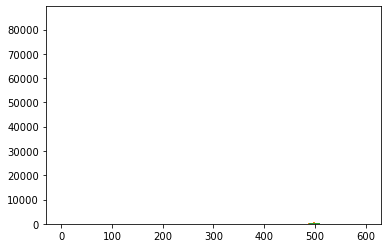

In [269]:
pxg=model.predict_proba(data_train[uncorrelated])[:,1]
plt.hist(pxg, bins=100);
# plt.yscale('log')
true=pxg>0.7
plt.hist(data_train.v0_ks_mass[true], bins=100);
#just for fun
#just for fun
pxgt=model.predict_proba(data_test[uncorrelated])[:,1]
true_test=pxgt>0.7
plt.hist(data_test.v0_ks_mass[true_test], bins=100);


eval_s = [(data_train[uncorrelated], true), (data_test[uncorrelated], true_test)]
modeldata = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 200)
modeldata.fit(data_train[uncorrelated], true,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")

Completed fit with Chi2: 95.2, p-val: 0.361 and the total amount of signal 4209 +/- 146, background: 74357
Completed fit with Chi2: 94.3, p-val: 0.386 and the total amount of signal 3508 +/- 171, background: 74273
Completed fit with Chi2: 93.2, p-val: 0.415 and the total amount of signal 2845 +/- 164, background: 74149
Completed fit with Chi2: 92.7, p-val: 0.430 and the total amount of signal 2187 +/- 177, background: 74023
Completed fit with Chi2: 92.1, p-val: 0.449 and the total amount of signal 1563 +/- 42, background: 73860
Completed fit with Chi2: 90.8, p-val: 0.486 and the total amount of signal 1035 +/- 348, background: 73603
Completed fit with Chi2: 93.9, p-val: 0.397 and the total amount of signal 615 +/- 152, background: 73238
Completed fit with Chi2: 95.1, p-val: 0.363 and the total amount of signal 346 +/- 73, background: 72721
Completed fit with Chi2: 95.3, p-val: 0.358 and the total amount of signal 140 +/- 136, background: 72140
Completed fit with Chi2: 94.3, p-val: 0.38

Completed fit with Chi2: 94.8, p-val: 0.370 and the total amount of signal 97 +/- 102, background: 17189
Completed fit with Chi2: 98.5, p-val: 0.277 and the total amount of signal 101 +/- 74, background: 16398
Completed fit with Chi2: 94.1, p-val: 0.391 and the total amount of signal 93 +/- 57, background: 15621
Completed fit with Chi2: 93.8, p-val: 0.398 and the total amount of signal 77 +/- 57, background: 14851
Completed fit with Chi2: 95.3, p-val: 0.357 and the total amount of signal 70 +/- 56, background: 14072
No valid minimum found!
Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 57 +/- 3565, background: 13300
Completed fit with Chi2: 103.8, p-val: 0.169 and the total amount of signal 52 +/- 11, background: 12519
Completed fit with Chi2: 100.9, p-val: 0.223 and the total amount of signal 38 +/- 0, background: 11747
Completed fit with Chi2: 98.0, p-val: 0.290 and the total amount of signal 25 +/- 25, background: 10975
Completed fit with Chi2: 93.4, p-va

-0.025700767390399573

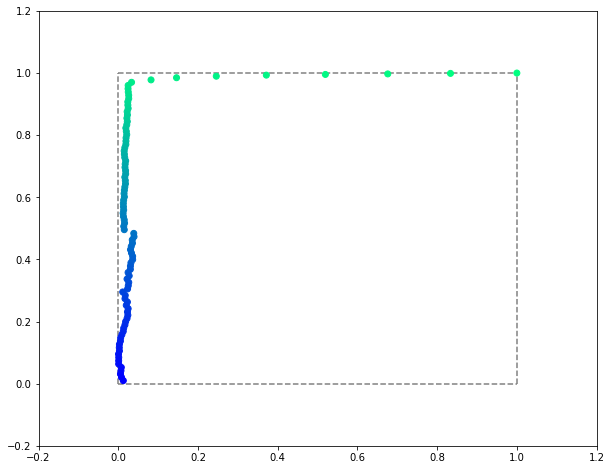

In [271]:
fig1, ax1=plt.subplots(figsize=(10,8))
hm.roc_curve_data(data_test.v0_ks_mass, p_final, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = True, plimit = 0.01)

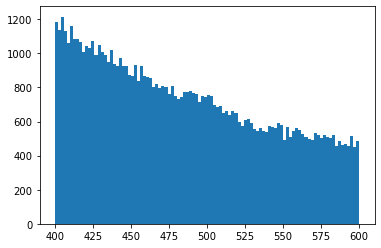

In [274]:
p_final=modeldata.predict_proba(data_test[uncorrelated])[:,0]
true_final=p_final>0.8
plt.hist(data_test.v0_ks_mass[true_final], bins=100);